In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip install imblearn
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 82.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
/kaggle/input/cybersecurity-intrusion-detection-dataset/httpswww.kaggle.comdatasetsdnkumarscybersecurity-intrusion-detection-dataset.csv


# AI-powered Intrusion Detection System

> **This Notebook designed to develop an AI-powered Intrusion Detection System for a company’s network using a labeled dataset containing both network traffic features and user behavior features. The goal of this system is to detect cyber intrusions in real-time while minimizing false alarms.**



## **I** About Dataset

Cybersecurity Intrusion Detection Dataset is designed for detecting cyber intrusions based on network traffic and user behavior. Below, I’ll explain each aspect in detail, including the dataset structure, feature importance, possible analysis approaches, and how it can be used for machine learning.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("/kaggle/input/cybersecurity-intrusion-detection-dataset/httpswww.kaggle.comdatasetsdnkumarscybersecurity-intrusion-detection-dataset.csv") 

data.head(10)

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0
5,SID_00006,453,UDP,5,380.471550,AES,0.422486,2,Chrome,1,0
6,SID_00007,815,ICMP,4,728.107165,AES,0.413772,1,Chrome,0,1
7,SID_00008,653,TCP,3,12.599906,DES,0.097719,3,Chrome,1,1
8,SID_00009,406,TCP,2,542.558895,NaN,0.294580,0,Chrome,1,0
9,SID_00010,608,UDP,6,531.944107,NaN,0.424117,1,Chrome,0,0


## 1. Understanding the Features

### A. Network-Based Features

#### 1. network_packet_size (Packet Size in Bytes)
* Represents the size of network packets, ranging between 64 to 1500 bytes.
* Packets on the lower end (64 bytes) may indicate control messages, while larger packets (~1500 bytes) often carry bulk data.
* Attackers may use abnormally small or large packets for reconnaissance or exploitation attempts.


In [3]:
data['network_packet_size'].describe()

count    9537.000000
mean      500.430639
std       198.379364
min        64.000000
25%       365.000000
50%       499.000000
75%       635.000000
max      1285.000000
Name: network_packet_size, dtype: float64

#### 2. protocol_type (Communication Protocol)
* The protocol used in the session: TCP, UDP, or ICMP.
* TCP (Transmission Control Protocol): Reliable, connection-oriented (common for HTTP, HTTPS, SSH).
* UDP (User Datagram Protocol): Faster but less reliable (used for VoIP, streaming).
* ICMP (Internet Control Message Protocol): Used for network diagnostics (ping); often abused in Denial-of-Service (DoS) attacks.


In [4]:
data['protocol_type'].unique()

array(['TCP', 'UDP', 'ICMP'], dtype=object)

#### 3. encryption_used (Encryption Protocol)
* Values: AES, DES, None.
* AES (Advanced Encryption Standard): Strong encryption, commonly used.
* DES (Data Encryption Standard): Older encryption, weaker security.
* None: Indicates unencrypted communication, which can be risky.

Attackers might use no encryption to avoid detection or weak encryption to exploit vulnerabilities.

In [5]:
data['encryption_used'].unique()

array(['DES', 'AES', nan], dtype=object)

### B. User Behavior-Based Features
These features track user activities, such as login attempts and session duration.

#### 1. login_attempts (Number of Logins)
* High values might indicate brute-force attacks (repeated login attempts).
* Typical users have 1–3 login attempts, while an attack may have hundreds or thousands.


In [6]:
data['login_attempts'].unique()

array([ 4,  3,  5,  2,  6,  9,  8,  1,  7, 10, 12, 13, 11])

#### 2.session_duration (Session Length in Seconds)
* A very long session might indicate unauthorized access or persistence by an attacker.
* Attackers may try to stay connected to maintain access.


In [7]:
data['session_duration'].describe()

count    9537.000000
mean      792.745312
std       786.560144
min         0.500000
25%       231.953006
50%       556.277457
75%      1105.380602
max      7190.392213
Name: session_duration, dtype: float64

#### 3. failed_logins (Failed Login Attempts)
* High failed login counts indicate credential stuffing or dictionary attacks.
* Many failed attempts followed by a successful login could suggest an account was compromised.

In [8]:
data['failed_logins'].unique()

array([1, 0, 2, 3, 4, 5])

#### 4.unusual_time_access (Login Time Anomaly)
* A binary flag (0 or 1) indicating whether access happened at an unusual time.
* Attackers often operate outside normal business hours to evade detection.


In [9]:
data['unusual_time_access'].unique()

array([0, 1])

#### 5.ip_reputation_score (Trustworthiness of IP Address)
* A score from 0 to 1, where higher values indicate suspicious activity.
* IP addresses associated with botnets, spam, or previous attacks tend to have higher scores.

In [10]:
data['ip_reputation_score'].describe()

count    9537.000000
mean        0.331338
std         0.177175
min         0.002497
25%         0.191946
50%         0.314778
75%         0.453388
max         0.924299
Name: ip_reputation_score, dtype: float64


#### 6.browser_type (User’s Browser)
* Common browsers: Chrome, Firefox, Edge, Safari.
* Unknown: Could be an indicator of automated scripts or bots.

In [11]:
data['browser_type'].unique()

array(['Edge', 'Firefox', 'Chrome', 'Unknown', 'Safari'], dtype=object)

## **II** Data Exploration & Cleaning

In [12]:
# Show all infos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


In [13]:
# Check missing values
data.isnull().sum()

session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64

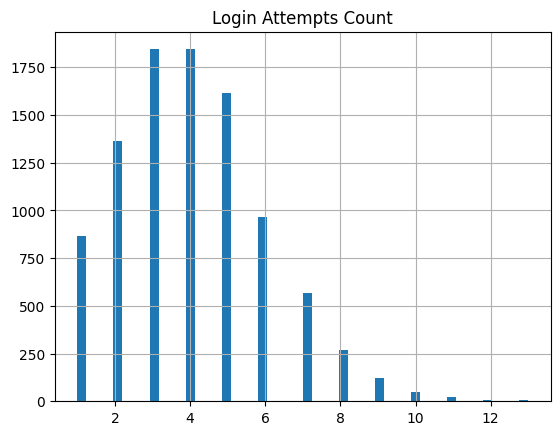

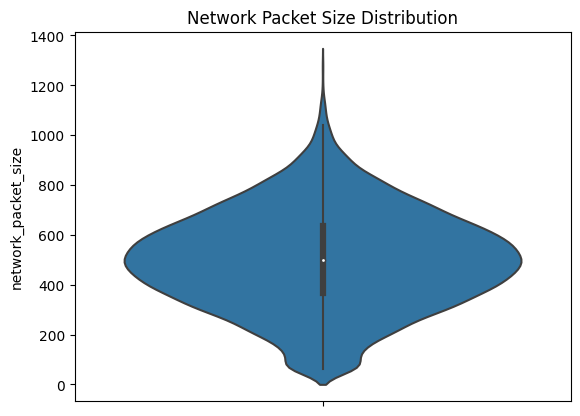

In [14]:
# Some distributions 

# Login attempt counter
data['login_attempts'].hist(bins=50)
plt.title("Login Attempts Count")
plt.show()

# Network Packet Size
sns.violinplot(y=data['network_packet_size'])
plt.title("Network Packet Size Distribution")
plt.show()


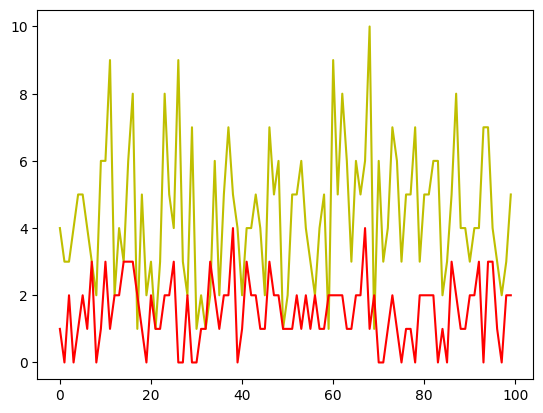

/tmp/ipykernel_13/577826006.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['session_duration'], shade=True, ax=axes[1])
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


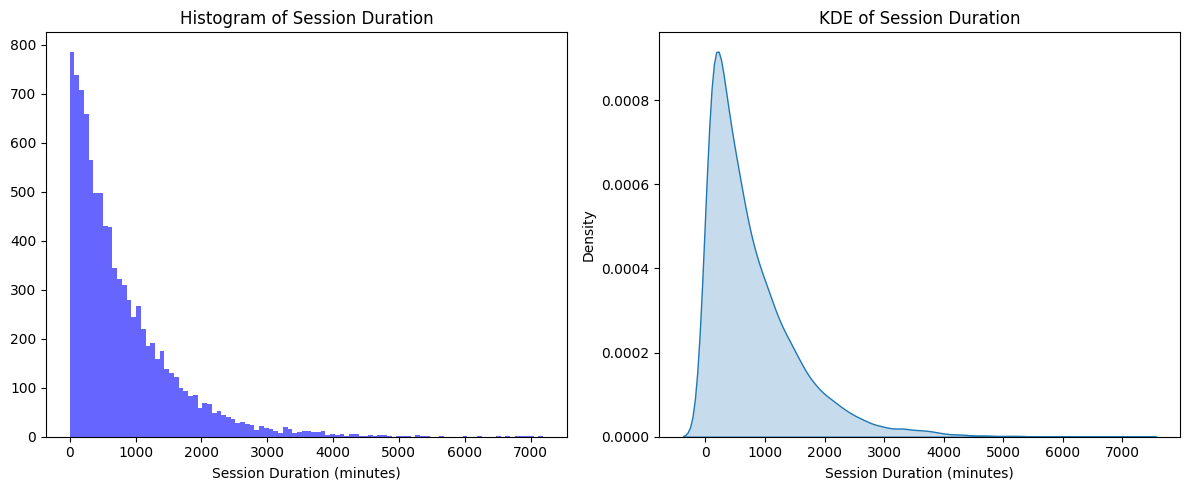

In [15]:
# Login attempts & failed logins compared
plt.plot(data['login_attempts'].head(100), color = 'y')
plt.plot(data['failed_logins'].head(100), color = 'r')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Right plot: Histogram (density)
axes[0].hist(data['session_duration'], bins=100, density=False, alpha=0.6, color='b')
axes[0].set_xlabel('Session Duration (minutes)')
axes[0].set_title('Histogram of Session Duration')

# Left plot: KDE
sns.kdeplot(data['session_duration'], shade=True, ax=axes[1])
axes[1].set_xlabel('Session Duration (minutes)')
axes[1].set_title('KDE of Session Duration')



plt.tight_layout()
plt.show()

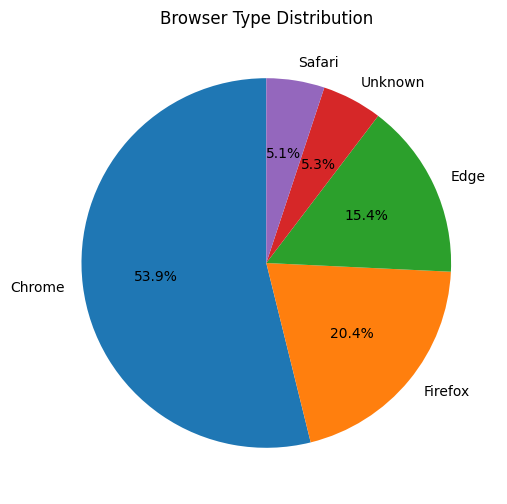

In [16]:
# Count frequency of each browser type
browser_counts = data['browser_type'].value_counts()

# Plot as pie chart
plt.figure(figsize=(6, 6))
plt.pie(browser_counts, 
        labels=browser_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Browser Type Distribution")
plt.show()

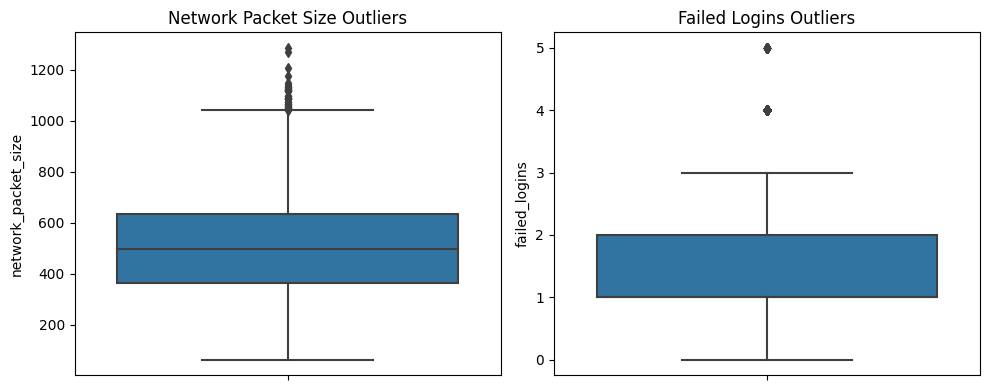

In [17]:
# Network Packet Size and Failed Logins Outliers
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(y=data['network_packet_size'])
plt.title('Network Packet Size Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(y=data['failed_logins'])
plt.title('Failed Logins Outliers')

plt.tight_layout()
plt.show()

In [18]:
# Encoded categorical features
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data_encd = data.copy()

# Columns to encode
cat_columns = ['session_id', 'protocol_type', 'encryption_used', 'browser_type']

# Encode each categorical column
for col in cat_columns:
    data_encd[col] = data_encd[col].astype('str')          # Ensure strings, NaN become 'nan'
    data_encd[col] = le.fit_transform(data_encd[col])
    
# Ensure attack_detected is numeric
data_encd['attack_detected'] = pd.to_numeric(data_encd['attack_detected'], errors='coerce')

In [19]:
# Categorical columns after encoding 
data_encd[cat_columns].head(10)

,session_id,protocol_type,encryption_used,browser_type
0,0,1,1,1
1,1,1,1,2
2,2,1,1,0
3,3,2,1,4
4,4,1,0,2
5,5,2,0,0
6,6,0,0,0
7,7,1,1,0
8,8,1,2,0
9,9,2,2,0


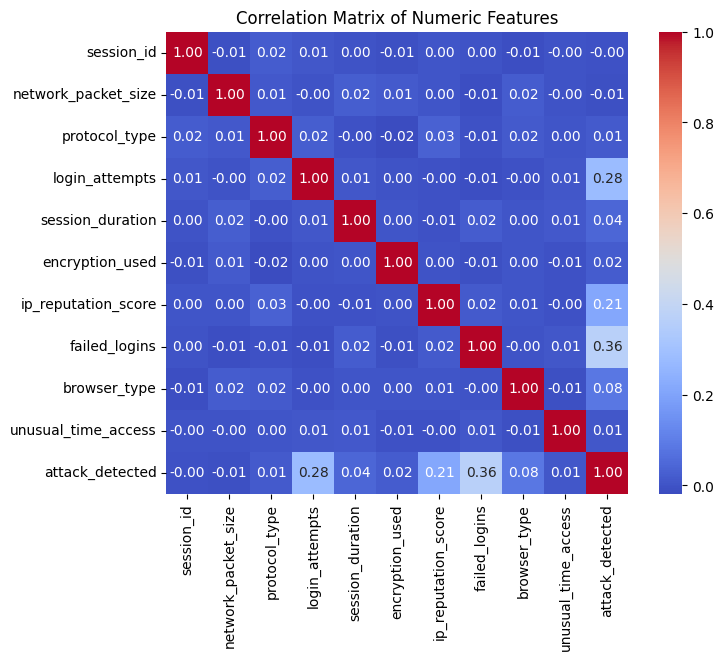

In [20]:
# Convert 'attack_detected' to numeric if there are NaNs and it isn't already
# df_corr = data_encd.copy()
# df_corr['attack_detected'] = pd.to_numeric(df_corr['attack_detected'], errors='coerce')

# Compute correlation
corr_matrix = data_encd.corr()

# Display correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

## **III. Feature Engineering**


### Login success ratio = login_attempts / (login_attempts + failed_logins)

In [21]:
# Create Login success column
data_encd['success_ratio'] = data_encd['login_attempts'] / (data_encd['login_attempts'] + data_encd['failed_logins'])
data_encd[['login_attempts', 'failed_logins', 'success_ratio']].head(10)

,login_attempts,failed_logins,success_ratio
0,4,1,0.800000
1,3,0,1.000000
2,3,2,0.600000
3,4,0,1.000000
4,5,1,0.833333
5,5,2,0.714286
6,4,1,0.800000
7,3,3,0.500000
8,2,0,1.000000
9,6,1,0.857143


### Session anomaly score = session_duration * unusual_time_access

In [22]:
# Create anomaly score column
data_encd['anomaly_score'] = data_encd['session_duration'] * data_encd['unusual_time_access']
data_encd[['session_duration', 'unusual_time_access', 'anomaly_score']].head(10)

,session_duration,unusual_time_access,anomaly_score
0,492.983263,0,0.000000
1,1557.996461,0,0.000000
2,75.044262,0,0.000000
3,601.248835,0,0.000000
4,532.540888,0,0.000000
5,380.471550,1,380.471550
6,728.107165,0,0.000000
7,12.599906,1,12.599906
8,542.558895,1,542.558895
9,531.944107,0,0.000000


### Normalize/scale continuous features for ML models

In [23]:
print('Before Normalization : ')
data_encd.head(10)

Before Normalization : 


,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected,success_ratio,anomaly_score
0,0,599,1,4,492.983263,1,0.606818,1,1,0,1,0.800000,0.000000
1,1,472,1,3,1557.996461,1,0.301569,0,2,0,0,1.000000,0.000000
2,2,629,1,3,75.044262,1,0.739164,2,0,0,1,0.600000,0.000000
3,3,804,2,4,601.248835,1,0.123267,0,4,0,1,1.000000,0.000000
4,4,453,1,5,532.540888,0,0.054874,1,2,0,0,0.833333,0.000000
5,5,453,2,5,380.471550,0,0.422486,2,0,1,0,0.714286,380.471550
6,6,815,0,4,728.107165,0,0.413772,1,0,0,1,0.800000,0.000000
7,7,653,1,3,12.599906,1,0.097719,3,0,1,1,0.500000,12.599906
8,8,406,1,2,542.558895,2,0.294580,0,0,1,0,1.000000,542.558895
9,9,608,2,6,531.944107,2,0.424117,1,0,0,0,0.857143,0.000000


In [24]:
from sklearn.preprocessing import MinMaxScaler

# Contnuous Columns to scale
cntns_cols = ['session_duration', 'ip_reputation_score','success_ratio', 'anomaly_score']

minmax_scaler = MinMaxScaler()
data_minmax = data_encd.copy()
data_minmax[cntns_cols] = minmax_scaler.fit_transform(data_encd[cntns_cols])

print(data_minmax.head(10))

   session_id  network_packet_size  protocol_type  login_attempts  \
0           0                  599              1               4   
1           1                  472              1               3   
2           2                  629              1               3   
3           3                  804              2               4   
4           4                  453              1               5   
5           5                  453              2               5   
6           6                  815              0               4   
7           7                  653              1               3   
8           8                  406              1               2   
9           9                  608              2               6   

   session_duration  encryption_used  ip_reputation_score  failed_logins  \
0          0.068497                1             0.655587              1   
1          0.216623                1             0.324443              0   
2          0

### Handle imbalanced target (attack_detected) with SMOTE or class weights.


In [25]:
# from imblearn.over_sampling import SMOTE

# X = data_minmax
# y = data_minmax['attack_detected'].astype(int)   # Ensure integer type

# # SMOTE upsampling
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y)

# print("Original class distribution:", y.value_counts())
# print("After SMOTE:", pd.Series(y_resampled).value_counts())
